# Logistic Regression Modeling

In this notebook, we:
- Train a baseline Logistic Regression model
- Apply Lasso (L1) and Ridge (L2) regularization
- Tune hyperparameters using GridSearchCV
- Compare models based on ROC-AUC and other classification metrics

This notebook sets the benchmark for tree-based models later.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import joblib

In [3]:
#Load processed data

X_train = joblib.load('X_train_smote.pkl')
y_train = joblib.load('y_train_smote.pkl')
X_test = joblib.load('X_test.pkl')
y_test = joblib.load('y_test.pkl')

## 1. Baseline Logistic Regression

In [4]:
# Baseline logistic regression with default hyperparameters
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate
print("Classification Report (Baseline):")
print(classification_report(y_test, y_pred_baseline))
print("ROC-AUC (Baseline):", roc_auc_score(y_test, baseline_model.predict_proba(X_test)[:, 1]))

Classification Report (Baseline):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.98      0.99     85443

ROC-AUC (Baseline): 0.9660304539254068


This model uses default settings. It serves as a reference to evaluate if regularization and tuning improve performance.

## 2. Lasso & Ridge Regularization

In [5]:
param_grid = {'C': [0.1, 1, 10]}  # Reduce options to test faster

In [7]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [8]:
# Lasso

lasso = GridSearchCV(
    LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000),
    param_grid, cv=cv, scoring='roc_auc', n_jobs=-1
)
lasso.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, penalty='l1',
                                          solver='liblinear'),
             n_jobs=-1, param_grid={'C': [0.1, 1, 10]}, scoring='roc_auc')

In [10]:
# Ridge

ridge = GridSearchCV(
    LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000),
    param_grid, cv=cv, scoring='roc_auc', n_jobs=-1
)
ridge.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             n_jobs=-1, param_grid={'C': [0.1, 1, 10]}, scoring='roc_auc')

In [11]:
print("Best C for Lasso:", lasso.best_params_)
print("Best ROC-AUC (Lasso):", lasso.best_score_)

print("Best C for Ridge:", ridge.best_params_)
print("Best ROC-AUC (Ridge):", ridge.best_score_)

Best C for Lasso: {'C': 10}
Best ROC-AUC (Lasso): 0.9934205547338729
Best C for Ridge: {'C': 10}
Best ROC-AUC (Ridge): 0.993469179716214


In [12]:
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"\n{name} – ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(classification_report(y_test, y_pred))
    return y_proba

In [13]:
proba_baseline = evaluate_model("Baseline", baseline_model, X_test, y_test)
proba_lasso = evaluate_model("Lasso", lasso.best_estimator_, X_test, y_test)
proba_ridge = evaluate_model("Ridge", ridge.best_estimator_, X_test, y_test)


Baseline – ROC-AUC: 0.9660
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.98      0.99     85443


Lasso – ROC-AUC: 0.9659
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.98      0.99     85443


Ridge – ROC-AUC: 0.9660
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85

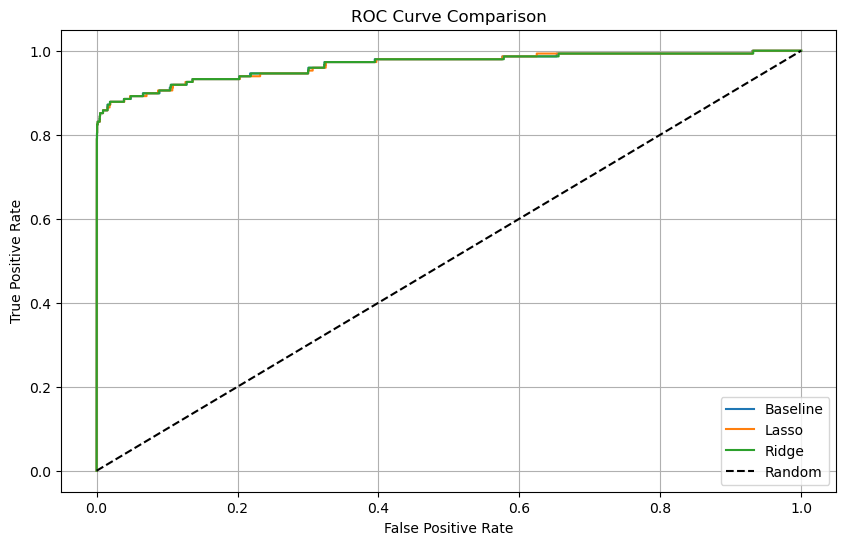

In [16]:
# Plot ROC Curves

from sklearn.metrics import roc_curve

fpr_b, tpr_b, _ = roc_curve(y_test, proba_baseline)
fpr_l, tpr_l, _ = roc_curve(y_test, proba_lasso)
fpr_r, tpr_r, _ = roc_curve(y_test, proba_ridge)

plt.figure(figsize=(10, 6))
plt.plot(fpr_b, tpr_b, label='Baseline')
plt.plot(fpr_l, tpr_l, label='Lasso')
plt.plot(fpr_r, tpr_r, label='Ridge')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

## 3. Feature Importance (Lasso)

Lasso acts as implicit feature selection by shrinking coefficients of less useful features to zero.

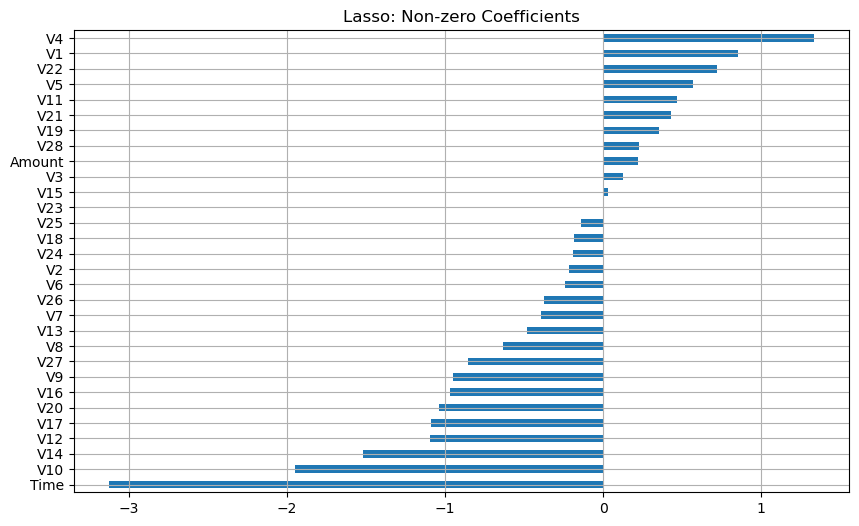

In [15]:
coef = pd.Series(lasso.best_estimator_.coef_[0], index=X_train.columns)
selected = coef[coef != 0].sort_values()

plt.figure(figsize=(10, 6))
selected.plot(kind='barh')
plt.title('Lasso: Non-zero Coefficients')
plt.grid(True)
plt.show()

## 4. Evaluation Summary

All three models — baseline, Lasso (L1), and Ridge (L2) — achieved very similar performance:

- **ROC-AUC**: ~0.966 for all models
- **Recall (Class 1)**: 0.88 → very strong ability to catch fraud cases
- **Precision (Class 1)**: Low (0.06), indicating false positives are common

Lasso performed implicit feature selection but did not significantly outperform Ridge or the baseline model. This suggests that the full feature set still holds useful information.

**Next step**: Compare this benchmark against tree-based models (Random Forest, XGBoost) and evaluate whether they provide better balance between precision and recall.